<a href="https://colab.research.google.com/github/ZaUt-bio/SincNet-used-for-Parkinsons-Disease-detection/blob/main/SincNet_filters_visualization_initials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
config = {
    'windowing': {
        'fs': 512,
        'cw_len': 500,
        'cw_shift': 5
    },
    'cnn': {
        'cnn_N_filt': '100,64,128',
        'cnn_len_filt': '257,20,10',
        'cnn_max_pool_len': '1,5,2',
        'cnn_use_laynorm_inp': 'False',
        'cnn_use_batchnorm_inp': 'False',
        'cnn_use_laynorm': 'False,False,False,False',
        'cnn_use_batchnorm': 'False,False,False,False',
        'cnn_act':  'leaky_relu,leaky_relu,leaky_relu',
        'cnn_drop': '0.0,0.0,0.0,0.0'
    },
    'dnn': {
        'fc_lay': '1024',
        'fc_drop': '0.25,0.0',
        'fc_use_laynorm_inp': 'False',
        'fc_use_batchnorm_inp': 'False',
        'fc_use_batchnorm': 'False,False',
        'fc_use_laynorm': 'False,False',
        'fc_act': 'leaky_relu,relu'
    },
    'class': {
        'class_lay': '1',
        'class_drop': '0.0',
        'class_use_laynorm_inp': 'False',
        'class_use_batchnorm_inp': 'False',
        'class_use_batchnorm': 'False',
        'class_use_laynorm': 'False',
        'class_act': 'sigmoid' #'softmax'
    },
    'optimization': {
        'lr': '0.0001',
        'batch_size': '47',
        'N_epochs': '10',
        'N_batches': '30',
        'N_eval_epoch': '1',
        'seed': '1234'
    }
}
INP_dim = 512
fs = int(512)
fold = 4 # done = 0 & 1 & 2 & 3

# base of the code

## 2. data_io

In [ ]:
# removed functions: read_conf & read_conf_inp & create_batches_rnd
import configparser as ConfigParser
from optparse import OptionParser
import numpy as np
import scipy
import torch


def ReadList(list_file):
    f = open(list_file, "r")
    lines = f.readlines()
    list_sig = []
    for x in lines:
        list_sig.append(x.rstrip())
    f.close()
    return list_sig



def str_to_bool(s):
    print(s)
    if s == 'True':
        return True
    elif s == 'False':
        return False
    else:
        raise ValueError



## flip and sinc functions

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import math


def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, -1, -1),
                                                  ('cpu', 'cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)


def sinc(band, t_right):
    y_right = torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
    y_left = flip(y_right, 0)

    y = torch.cat([y_left, Variable(torch.ones(1)).cuda(), y_right])

    return y

## SincConv_fast

In [ ]:

class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters for EEG-based emotion recognition
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 500.
    Usage
    -----
    See `torch.nn.Conv2d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=512, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=0.01, min_band_hz=10):

        super(SincConv_fast, self).__init__()

        if in_channels != 1:
            # msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (
                  in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size+1

        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in
        # Mel scale around the complete range of the pre-filtered EEG trial
        low_hz = 0.5
        high_hz = 50 # according to the preprocessing high_low frequencies
        #print(out_channels)
        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)

        hz = self.to_hz(mel)

        self.hz = hz # این در کل مارونلی نیستش

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))
        # our learnable parameter within neural network model
        # setting the Hamming window
        # computing only half of the window
        n_lin = torch.linspace(0, (self.kernel_size/2)-1,
                               steps=int((self.kernel_size/2)))
        self.window_ = 0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size)
        n = (self.kernel_size - 1) / 2.0
        # Due to symmetry, I only need half of the time axes
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate

    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz + torch.abs(self.low_hz_)

        high = torch.clamp(low + self.min_band_hz +
                           torch.abs(self.band_hz_), self.min_low_hz, self.sample_rate/2)
        band = (high-low)[:, 0]

        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET).
        # I just have expanded the sinc and simplified the terms. This way I avoid several useless computations (Mirco).
        band_pass_left = ((torch.sin(f_times_t_high) -
                           torch.sin(f_times_t_low))/(self.n_/2))*self.window_
        band_pass_center = 2*band.view(-1, 1)
        band_pass_right = torch.flip(band_pass_left, dims=[1])

        band_pass = torch.cat(
            [band_pass_left, band_pass_center, band_pass_right], dim=1)

        band_pass = band_pass / (2*band[:, None])

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)



## act_fun and LayerNorm

In [ ]:

def act_fun(act_type):
    """activation function selection function
    Parameters for any type of Conv/DNN layer
    act_type: str
         activation function name, and correlate this with all the possible activation functions in Pytorch
    """
    if act_type == "relu":
        return nn.ReLU()

    if act_type == "tanh":
        return nn.Tanh()

    if act_type == "sigmoid":
        return nn.Sigmoid()

    if act_type == "leaky_relu":
        return nn.LeakyReLU(0.2)

    if act_type == "elu":
        return nn.ELU()

    if act_type == "gelu":
        return nn.GELU()

    if act_type == "softmax":
        return nn.LogSoftmax(dim=1)

    if act_type == "linear":
        # initializzed like this, but not used in forward!
        return nn.LeakyReLU(1)
    if act_type == "swish":
        return nn.SiLU()
    if act_type == "hardswish":
        return nn.Hardswish()


class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta



## MLP

In [ ]:

class MLP(nn.Module):
    """
    MLP/DNN layer constructor [dnn/fc] option values from the cfg file are parsed here
    """
    def __init__(self, options):
        super(MLP, self).__init__()

        self.input_dim = int(options['input_dim'])
        self.fc_lay = options['fc_lay']
        self.fc_drop = options['fc_drop']
        self.fc_use_batchnorm = options['fc_use_batchnorm']
        self.fc_use_laynorm = options['fc_use_laynorm']
        self.fc_use_laynorm_inp = options['fc_use_laynorm_inp']
        self.fc_use_batchnorm_inp = options['fc_use_batchnorm_inp']
        self.fc_act = options['fc_act']

        self.wx = nn.ModuleList([])
        self.bn = nn.ModuleList([])
        self.ln = nn.ModuleList([])
        self.act = nn.ModuleList([])
        self.drop = nn.ModuleList([])

        # input layer normalization
        if self.fc_use_laynorm_inp:
            self.ln0 = LayerNorm(self.input_dim)

        # input batch normalization
        if self.fc_use_batchnorm_inp:
            self.bn0 = nn.BatchNorm1d([self.input_dim], momentum=0.05)

        self.N_fc_lay = len(self.fc_lay)

        current_input = self.input_dim

        # Initialization of hidden layers

        for i in range(self.N_fc_lay):

            #print('شماره حلقه :', i)
            # dropout
            self.drop.append(nn.Dropout(p=self.fc_drop[i]))

            # activation
            self.act.append(act_fun(self.fc_act[i]))

            add_bias = True

            # layer norm initialization
            self.ln.append(LayerNorm(self.fc_lay[i]))
            self.bn.append(nn.BatchNorm1d(self.fc_lay[i], momentum=0.05))

            if self.fc_use_laynorm[i] or self.fc_use_batchnorm[i]:
                add_bias = False

            # Linear operations
            self.wx.append(
                nn.Linear(current_input, self.fc_lay[i], bias=add_bias))

            # weight initialization
            self.wx[i].weight = torch.nn.Parameter(torch.Tensor(self.fc_lay[i], current_input).uniform_(
                -np.sqrt(0.01/(current_input+self.fc_lay[i])), np.sqrt(0.01/(current_input+self.fc_lay[i]))))
            self.wx[i].bias = torch.nn.Parameter(torch.zeros(self.fc_lay[i]))

            current_input = self.fc_lay[i]

    def forward(self, x):

        # Applying Layer/Batch Norm
        if bool(self.fc_use_laynorm_inp):
            x = self.ln0((x))

        if bool(self.fc_use_batchnorm_inp):
            x = self.bn0((x))

        for i in range(self.N_fc_lay):

            if self.fc_act[i] != 'linear':

                if self.fc_use_laynorm[i]:
                    x = self.drop[i](self.act[i](self.ln[i](self.wx[i](x))))

                if self.fc_use_batchnorm[i]:
                    x = self.drop[i](self.act[i](self.bn[i](self.wx[i](x))))

                if self.fc_use_batchnorm[i] is False and self.fc_use_laynorm[i] is False:
                    #print('x.shapeبرای فوروارد', x.shape)
                    #print('self.wx[i]',self.wx[i])
                    #print('self.act[i](self.wx[i](x))',(self.act[i](self.wx[i](x))).shape)
                    x = self.drop[i](self.act[i](self.wx[i](x)))

            else:
                if self.fc_use_laynorm[i]:
                    x = self.drop[i](self.ln[i](self.wx[i](x)))

                if self.fc_use_batchnorm[i]:
                    x = self.drop[i](self.bn[i](self.wx[i](x)))

                if self.fc_use_batchnorm[i] is False and self.fc_use_laynorm[i] is False:
                    x = self.drop[i](self.wx[i](x))

        return x



## SincNet

In [ ]:
class SincNet(nn.Module):
    """
    full SincNet constructor all option-values from the cfg file are parsed here
    """
    def __init__(self, options):
        super(SincNet, self).__init__()

        self.cnn_N_filt = options['cnn_N_filt']
        self.cnn_len_filt = options['cnn_len_filt']
        self.cnn_max_pool_len = options['cnn_max_pool_len']

        self.cnn_act = options['cnn_act']
        self.cnn_drop = options['cnn_drop']

        self.cnn_use_laynorm = options['cnn_use_laynorm']
        self.cnn_use_batchnorm = options['cnn_use_batchnorm']
        self.cnn_use_laynorm_inp = options['cnn_use_laynorm_inp']
        self.cnn_use_batchnorm_inp = options['cnn_use_batchnorm_inp']

        self.input_dim = int(options['input_dim'])

        self.fs = options['fs']

        self.N_cnn_lay = len(options['cnn_N_filt'])
        self.conv = nn.ModuleList([])
        self.bn = nn.ModuleList([])
        self.ln = nn.ModuleList([])
        self.act = nn.ModuleList([])
        self.drop = nn.ModuleList([])

        if self.cnn_use_laynorm_inp:
            self.ln0 = LayerNorm(self.input_dim)
        #else:
         #   self.ln.append(0)

        if self.cnn_use_batchnorm_inp:
            self.bn0 = nn.BatchNorm1d([self.input_dim], momentum=0.05)

        current_input = INP_dim #self.input_dim

        for i in range(self.N_cnn_lay):

            N_filt = int(self.cnn_N_filt[i])
            #len_filt = int(self.cnn_len_filt[i])# این اصن استافده نشده

            # dropout
            self.drop.append(nn.Dropout(p=self.cnn_drop[i]))

            # activation
            self.act.append(act_fun(self.cnn_act[i]))
            # layer norm initialization

            self.ln.append(LayerNorm(
                [N_filt, int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])]))# or 1???

            self.bn.append(nn.BatchNorm1d(N_filt, int(
                (current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i]), momentum=0.05))# or 1???


            if i == 0:

                self.conv.append(SincConv_fast(
                    self.cnn_N_filt[0], self.cnn_len_filt[0], self.fs))
            else:
                #self.conv.append(nn.Conv2d(self.cnn_N_filt[i-1], self.cnn_N_filt[i], [
                #                self.cnn_len_filt[i][0], self.cnn_len_filt[i][1]]))

                self.conv.append(nn.Conv1d(self.cnn_N_filt[i-1], self.cnn_N_filt[i], self.cnn_len_filt[i]))


            current_input = int(
                (current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])
            print('**current_input shape: {} and N_filt.shape: {}'.format(current_input,N_filt))



        self.out_dim = current_input*N_filt
        print('**current_input shape: {} and N_filt.shape: {}'.format(current_input,N_filt))


    def forward(self, x):
        batch = x.shape[0]
        seq_len = x.shape[1]

        if bool(self.cnn_use_laynorm_inp):
            x = self.ln0((x))

        if bool(self.cnn_use_batchnorm_inp):
            x = self.bn0((x))

        x = x.view(batch, 1, seq_len)
        for i in range(self.N_cnn_lay):
            #boogh = self.conv[i](x)

            if self.cnn_use_laynorm[i]:
                if i == 0:
                    x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(
                        torch.abs(self.conv[i](x)), self.cnn_max_pool_len[i]))))
                else:
                    x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(self.conv[i](
                        x), self.cnn_max_pool_len[i]))))

            if self.cnn_use_batchnorm[i]:
                x = self.drop[i](self.act[i](self.bn[i](F.max_pool1d(self.conv[i](
                    x), self.cnn_max_pool_len[i]))))

            if self.cnn_use_batchnorm[i] is False and self.cnn_use_laynorm[i] is False:
                x = self.drop[i](self.act[i](F.max_pool1d(self.conv[i](
                    x), self.cnn_max_pool_len[i])))


        x = x.view(batch, -1)

        return x

# Creation of Models

In [3]:
import numpy as np
from numpy import genfromtxt
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'
#data_folder = config['data']['data_folder']

# [windowing] section
INP_dim = 512
fs = int(512)
# [cnn] section
cnn_N_filt = list(map(int, config['cnn']['cnn_N_filt'].split(',')))
cnn_len_filt = list(map(int, config['cnn']['cnn_len_filt'].split(',')))
cnn_max_pool_len = list(map(int, config['cnn']['cnn_max_pool_len'].split(',')))
cnn_use_laynorm_inp = str_to_bool(config['cnn']['cnn_use_laynorm_inp'])
cnn_use_batchnorm_inp = str_to_bool(config['cnn']['cnn_use_batchnorm_inp'])
cnn_use_laynorm = list(map(str_to_bool, config['cnn']['cnn_use_laynorm'].split(',')))
cnn_use_batchnorm = list(
    map(str_to_bool, config['cnn']['cnn_use_batchnorm'].split(',')))
cnn_act = list(map(str, config['cnn']['cnn_act'].split(',')))
cnn_drop = list(map(float, config['cnn']['cnn_drop'].split(',')))

# [dnn] section
fc_lay = list(map(int, config['dnn']['fc_lay'].split(',')))
fc_drop = list(map(float, config['dnn']['fc_drop'].split(',')))
fc_use_laynorm_inp = str_to_bool(config['dnn']['fc_use_laynorm_inp'])
fc_use_batchnorm_inp = str_to_bool(config['dnn']['fc_use_batchnorm_inp'])
fc_use_batchnorm = list(
    map(str_to_bool, config['dnn']['fc_use_batchnorm'].split(',')))
fc_use_laynorm = list(
    map(str_to_bool, config['dnn']['fc_use_laynorm'].split(',')))
fc_act = list(map(str, config['dnn']['fc_act'].split(',')))

# [class] section
class_lay = list(map(int, config['class']['class_lay'].split(',')))
class_drop = list(map(float, config['class']['class_drop'].split(',')))
class_use_laynorm_inp = str_to_bool(config['class']['class_use_laynorm_inp'])
class_use_batchnorm_inp = str_to_bool(config['class']['class_use_batchnorm_inp'])
class_use_batchnorm = list(
    map(str_to_bool, config['class']['class_use_batchnorm'].split(',')))
class_use_laynorm = list(
    map(str_to_bool, config['class']['class_use_laynorm'].split(',')))
class_act = list(map(str, config['class']['class_act'].split(',')))

# [optimization] section
lr = float(config['optimization']['lr'])
batch_size = int(config['optimization']['batch_size'])
N_epochs = int(config['optimization']['N_epochs'])
N_batches = int(config['optimization']['N_batches'])
N_eval_epoch = int(config['optimization']['N_eval_epoch'])
seed = int(config['optimization']['seed'])

# loss function
#cost = nn.NLLLoss() ==> is applied only on models with the softmax function as an output activation layer.
cost = nn.BCELoss()


#------------------
# Reading cfg file you added as input from the command call
#options = read_conf()
#print(options)

#
CNN_arch = {'input_dim': INP_dim,
            'fs': fs,
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt': cnn_len_filt,
            'cnn_max_pool_len': cnn_max_pool_len,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm': cnn_use_laynorm,
            'cnn_use_batchnorm': cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop': cnn_drop,
            }

CNN_net = SincNet(CNN_arch)
DNN1_arch = {'input_dim': CNN_net.out_dim,
             'fc_lay': fc_lay,
             'fc_drop': fc_drop,
             'fc_use_batchnorm': fc_use_batchnorm,
             'fc_use_laynorm': fc_use_laynorm,
             'fc_use_laynorm_inp': fc_use_laynorm_inp,
             'fc_use_batchnorm_inp': fc_use_batchnorm_inp,
             'fc_act': fc_act,
             }

DNN1_net = MLP(DNN1_arch)
DNN2_arch = {'input_dim': fc_lay[-1],
             'fc_lay': class_lay,
             'fc_drop': class_drop,
             'fc_use_batchnorm': class_use_batchnorm,
             'fc_use_laynorm': class_use_laynorm,
             'fc_use_laynorm_inp': class_use_laynorm_inp,
             'fc_use_batchnorm_inp': class_use_batchnorm_inp,
             'fc_act': class_act,
             }


DNN2_net = MLP(DNN2_arch)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
**current_input shape: 256 and N_filt.shape: 100
**current_input shape: 47 and N_filt.shape: 64
**current_input shape: 19 and N_filt.shape: 128
**current_input shape: 19 and N_filt.shape: 128


In [4]:
print(CNN_net)
print(DNN1_net)
print(DNN2_net)


SincNet(
  (conv): ModuleList(
    (0): SincConv_fast()
    (1): Conv1d(100, 64, kernel_size=(20,), stride=(1,))
    (2): Conv1d(64, 128, kernel_size=(10,), stride=(1,))
  )
  (bn): ModuleList(
    (0): BatchNorm1d(100, eps=256, momentum=0.05, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=47, momentum=0.05, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=19, momentum=0.05, affine=True, track_running_stats=True)
  )
  (ln): ModuleList(
    (0-2): 3 x LayerNorm()
  )
  (act): ModuleList(
    (0-2): 3 x LeakyReLU(negative_slope=0.2)
  )
  (drop): ModuleList(
    (0-2): 3 x Dropout(p=0.0, inplace=False)
  )
)
MLP(
  (wx): ModuleList(
    (0): Linear(in_features=2432, out_features=1024, bias=True)
  )
  (bn): ModuleList(
    (0): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
  )
  (ln): ModuleList(
    (0): LayerNorm()
  )
  (act): ModuleList(
    (0): LeakyReLU(negative_slope=0.2)
  )
  (drop): ModuleList(
    

# Visualization of SincNet filters
You can access the filters in self.filters of your SincConv_fast layer even without training the model. However, you must initialize the model properly and perform at least one forward pass with dummy data through the SincConv_fast layer. This is because the self.filters attribute is created during the forward pass and not during the initialization of the model.

Here’s an example of how you can access the filters without training the model:

In [29]:
optimizer_CNN = optim.Adam(
    CNN_net.parameters(), lr=lr*10, eps=1e-8)
optimizer_DNN1 = optim.Adam(DNN1_net.parameters(), lr=lr,  eps=1e-8)
optimizer_DNN2 = optim.Adam(DNN2_net.parameters(), lr=lr,  eps=1e-8)
dummy_waveforms = torch.randn(1, 512)
pout=DNN2_net(DNN1_net(CNN_net(dummy_waveforms)))
# Access the filters
filters = CNN_net.conv[0].filters
print("Filters shape:", filters.shape)

Filters shape: torch.Size([100, 1, 257])


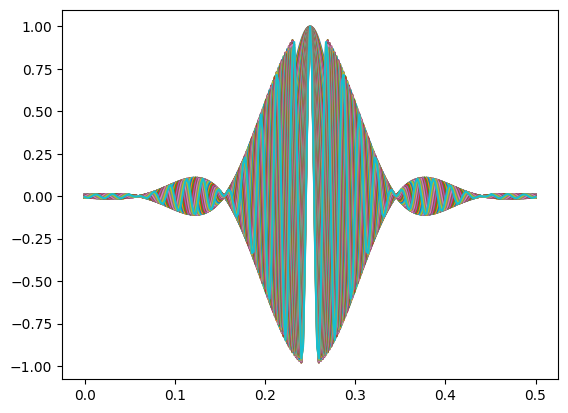

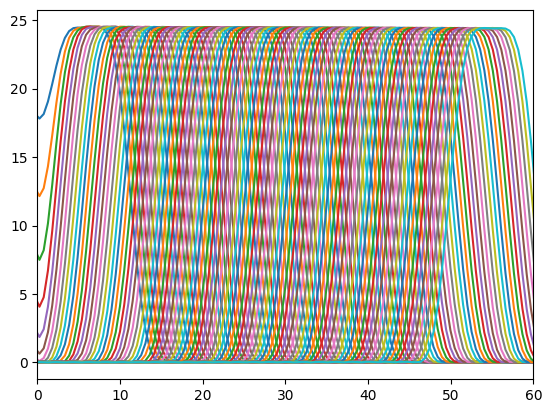

In [30]:
import matplotlib.pyplot as plt
a= CNN_net.conv[0].filters.detach().numpy()
x=np.linspace(0,0.5,257)
y=np.linspace(-256,256,1000)
for i in range(100):
  plt.figure(1)
  plt.plot(x,a[i,0,:])
  plt.figure(2)
  plt.plot(y,np.fft.fftshift(np.abs(np.fft.fft(a[i,0, :], 1000))))
plt.xlim([0,60])
plt.show()